## Data collection
We will use dataset of `hatespeechdata.com`.
Both of the data sets are in portuguese.
* A Hierarchically-Labeled Portuguese Hate Speech Dataset: https://b2share.eudat.eu/records/9005efe2d6be4293b63c3cffd4cf193e
* Offensive Comments in the Brazilian Web: A Dataset and Baseline Results: https://github.com/rogersdepelle/OffComBR



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('datasets\\final_dataset.csv')

Matplotlib is building the font cache; this may take a moment.


In [2]:
dataset.head()

,data,Hate.speech,length,laughs,bad_words,misspell
0,"['come', 'mel', 'morde', 'marimb']",0,32,0,0,1
1,"['pinto', 'orgulho']",0,28,0,1,0
2,"['vê', 'merda', 'crepúsculo', 'pra', 'cinebiog...",0,83,0,1,2
3,"['tapa', 'bundinha', 'cotovelada', 'costas']",0,51,0,1,0
4,"['diminutivo', 'inho', 'acompanha', 'trajetóri...",1,68,0,0,1


### Dealing with imbalanced data
With the plot below, we see that 20% of the data is related to hate, while 80% was detected with no hate.

We are going to use SMOTE technique to deal with it

Ref: "SMOTE: Synthetic Minority Over-sampling Technique". Available on https://arxiv.org/pdf/1106.1813.pdf.

In [4]:
from collections import Counter
counter = Counter(dataset['Hate.speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 2049, Class 1: 715


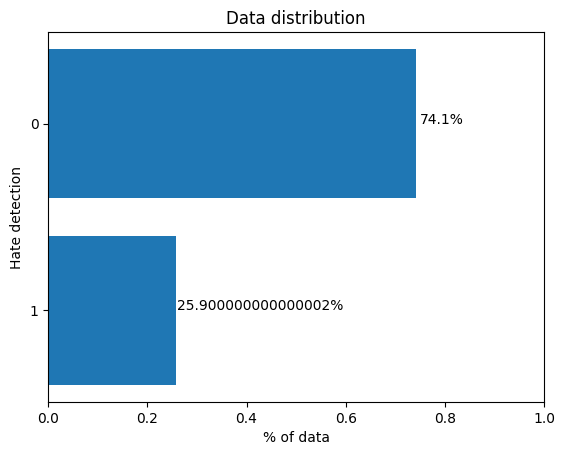

In [6]:
import numpy as np
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
data = (0, 1)
y_pos = [0,1]

count0 = counter[0]
count1 = counter[1]
total = count0 + count1
amount = (count0/total, count1/total)

ax.barh(y_pos, amount, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(data)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% of data')
ax.set_ylabel('Hate detection')
ax.set_title('Data distribution')
ax.text(0.75, 0, str(round(amount[0], 3)*100) + '%', color='black')
ax.text(0.26, 1, str(round(amount[1], 3)*100) + '%', color='black')

plt.xlim([0.0, 1.0])
plt.show()

In [8]:
from imblearn.over_sampling import SMOTE
# summarize class distribution
oversample = SMOTE()

a = dataset.copy()
a.head()

,data,Hate,length,laughs,bad_words,misspell
0,"['come', 'mel', 'morde', 'marimbondo']",0,32,0,0,1
1,"['pinto', 'orgulho']",0,28,0,1,0
2,"['vê', 'merda', 'crepúsculo', 'pra', 'cinebiog...",0,83,0,1,1
3,"['tapa', 'bundinha', 'cotovelada', 'costas']",0,51,0,1,1
4,"['diminutivo', 'inho', 'acompanha', 'trajetóri...",1,68,0,0,1


### Some analysis

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14D60958>,
      dtype=object)

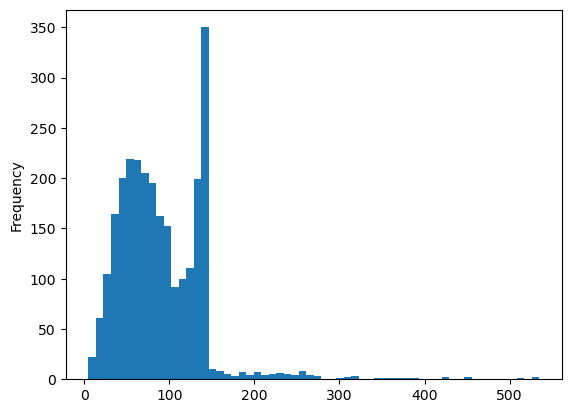

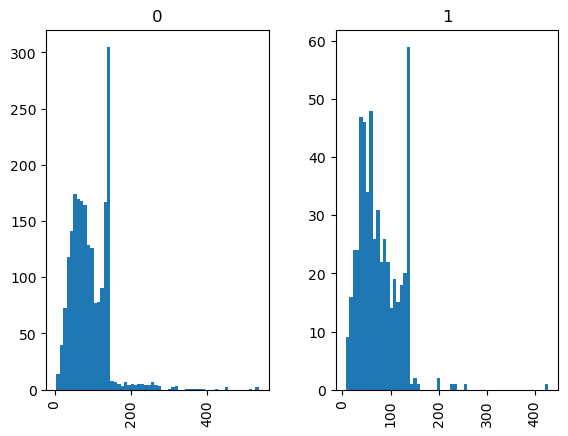

In [56]:
# checking it visually - length
fulldataset['length'].plot.hist(bins=60)
fulldataset.hist(column='length', by='Hate', bins=60)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x18E6A790>,
      dtype=object)

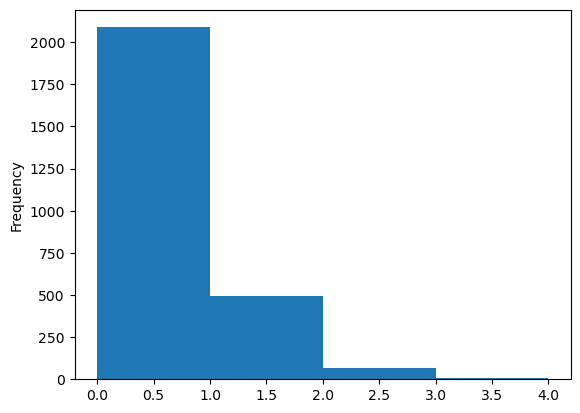

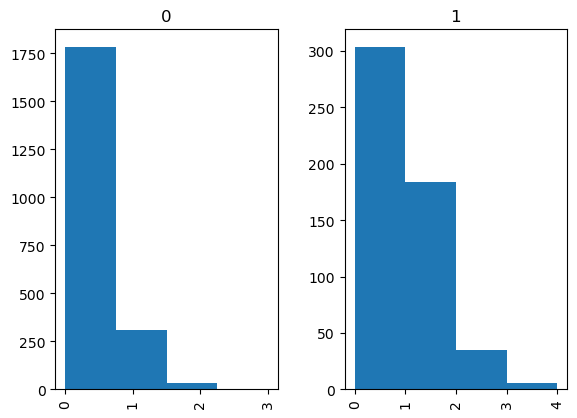

In [55]:
# checking it visually - bad words
full_dataset['bad_words'].plot.hist(bins=4)

full_dataset.hist(column='bad_words', by='Hate.speech', bins=4)

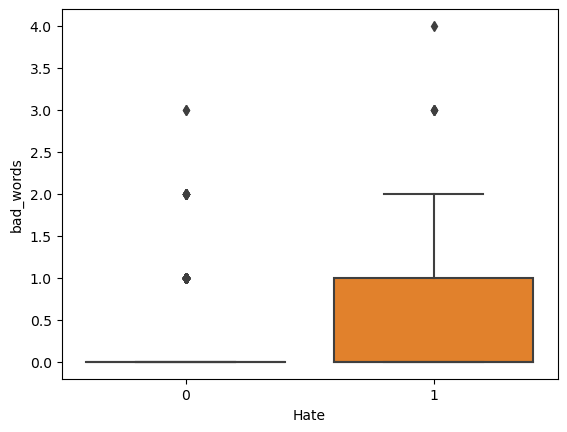

In [15]:
sns.boxplot(x='Hate', y='bad_words', data=dataset )

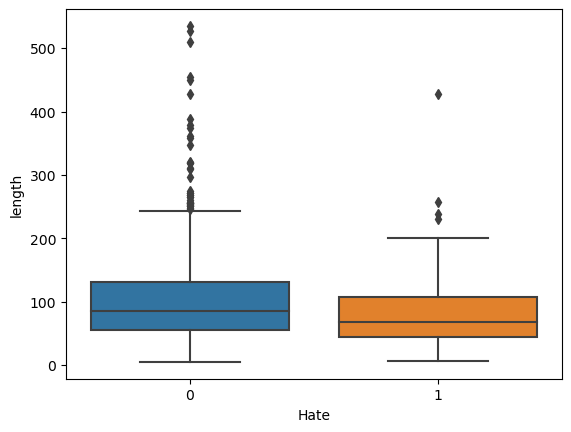

In [16]:
sns.boxplot(x='Hate', y='length', data=dataset )

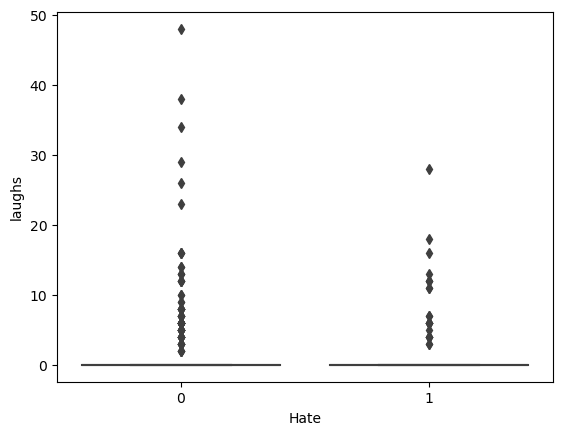

In [17]:
sns.boxplot(x='Hate', y='laughs', data=dataset )

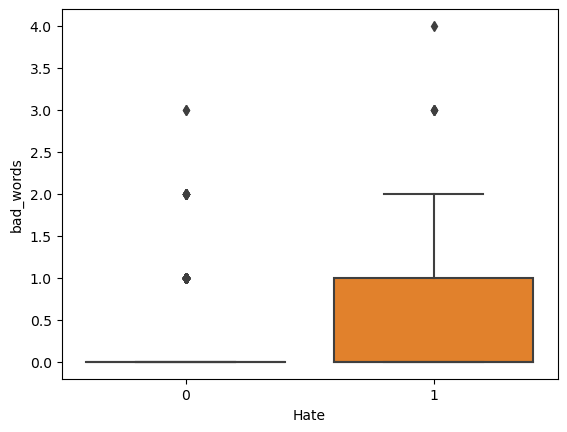

In [18]:
sns.boxplot(x='Hate', y='bad_words', data=dataset )

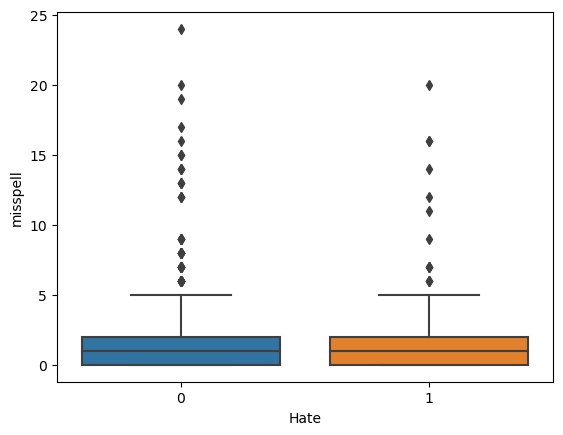

In [19]:
sns.boxplot(x='Hate', y='misspell', data=dataset )

Some conclusions until now are:
* comparing length and bad_words amount when hate speech is detected and when it is not. We see that:
 * class 0: length mean 9.4, bad_words mean 0.18
 * class 1: length mean 8.2, bad_words mean 0.52
* it means that text with hate detected are shorter and has more bad words, in general
* there are many outliers for length (and also for bad words), so we need to be careful

Text(0, 0.5, 'length')

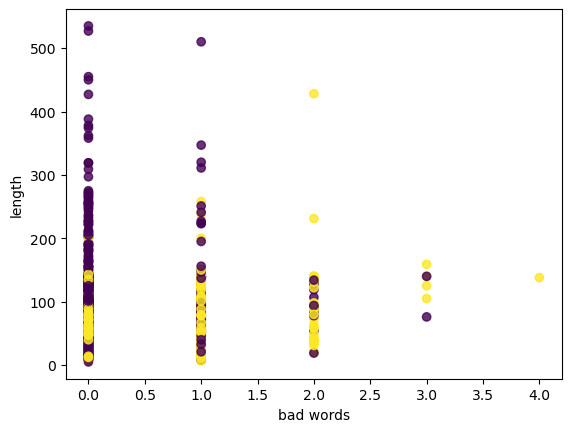

In [14]:
plt.scatter(dataset['bad_words'], dataset['length'], alpha=0.8,
            c=dataset['Hate'])
plt.xlabel('bad words')
plt.ylabel('length')

In [21]:
hate = dataset.groupby('Hate').mean()
hate.corr()

,length,laughs,bad_words,misspell
length,1.0,-1.0,-1.0,1.0
laughs,-1.0,1.0,1.0,-1.0
bad_words,-1.0,1.0,1.0,-1.0
misspell,1.0,-1.0,-1.0,1.0


### Process the data

In [24]:
import nltk #floresta, popular
#nltk.download()
#https://www.nltk.org/howto/portuguese_en.html

### Vectorization TF IDF
Convert each of the messages to a vector that scikit-learn algorithm models can work with.

1. Count how many times a word occurs in each message (Term Frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length

We will use CountVectorizer from sklearn

In [42]:
def join_text(text):
    text = text.replace('[', '').replace(']', '').replace('\'', '').split(', ')
    return ' '.join(text)


In [44]:
# make it a full text again
dataset['data'] = dataset['data'].apply(join_text)
dataset['data'].head()

0                            come mel morde marimbondo
1                                        pinto orgulho
2    vê merda crepúsculo pra cinebiografia chuck no...
3                      tapa bundinha cotovelada costas
4    diminutivo inho acompanha trajetória homem ver...
Name: data, dtype: object

In [51]:
dataset.groupby('Hate').describe()

length                                                       laughs  \
       count       mean        std  min   25%   50%    75%    max   count   
Hate                                                                        
0     2127.0  93.018806  51.931087  5.0  56.0  85.0  131.0  535.0  2127.0   
1      530.0  77.335849  43.351690  7.0  45.0  68.0  108.0  428.0   530.0   

                ... bad_words      misspell                                \
          mean  ...       75%  max    count      mean       std  min  25%   
Hate            ...                                                         
0     0.352139  ...       0.0  3.0   2127.0  1.468265  1.944383  0.0  0.0   
1     0.403774  ...       1.0  4.0    530.0  1.383019  1.973955  0.0  0.0   

                      
      50%  75%   max  
Hate                  
0     1.0  2.0  24.0  
1     1.0  2.0  20.0  

[2 rows x 32 columns]

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
bow_transformer = count_vectorizer.fit(dataset['data'])


In [32]:
print(bow_transformer.vocabulary_)
data_bow = bow_transformer.transform(full_dataset['data'])

full_dataset['data']

{'come': 1873, 'mel': 6076, 'morde': 6294, 'marimbondo': 5974, 'pinto': 7255, 'orgulho': 6828, 'vê': 9640, 'merda': 6118, 'crepúsculo': 2235, 'pra': 7443, 'cinebiografia': 1762, 'chuck': 1736, 'norris': 6625, 'tapa': 8878, 'bundinha': 1321, 'cotovelada': 2211, 'costas': 2207, 'diminutivo': 2707, 'inho': 5142, 'acompanha': 237, 'trajetória': 9141, 'homem': 4252, 'verdade': 9456, 'uns': 9314, 'saco': 8319, 'culhões': 2307, 'futebol': 3861, 'hoje': 4248, 'politicamente': 7337, 'correto': 2176, 'profissional': 7602, 'coisa': 1833, 'verdadeé': 9465, 'mariquinhafutebol': 5982, 'ter': 8956, 'porrada': 7380, 'água': 9765, 'ser': 8510, 'essencial': 3291, 'maricas': 5969, 'cerveja': 1637, 'barriga': 1036, 'calo': 1411, 'sexual': 8548, 'manda': 5904, 'ajustar': 412, 'calça': 1415, 'deixa': 2448, 'espaço': 3232, 'smith': 8616, 'wesson': 9668, 'entrar': 3131, 'ação': 971, 'morte': 6316, 'hipsters': 4230, 'camisetas': 1429, 'cores': 2157, 'citricas': 1775, 'meias': 6070, 'coloridinhas': 1866, 'cuequ

0                               come mel morde marimbondo
1                                           pinto orgulho
2       vê merda crepúsculo pra cinebiografia chuck no...
3                         tapa bundinha cotovelada costas
4       diminutivo inho acompanha trajetória homem ver...
                              ...                        
2654    cruz so agilidade poder nocaute zero cody veio...
2655    caros amigos enigmaticosnao deveriam comparalo...
2656             chamava pra atras escola sentava garotos
2657    jhalim rabei ate fiquei assustado comecei ler ...
2658    irmao honorato sempre falando verdades agindo ...
Name: data, Length: 2659, dtype: object

In [33]:
print('Shape of the sparse matrix ', data_bow.shape)

Shape of the sparse matrix  (2659, 10065)


In [34]:
data_bow.nnz

23495

In [35]:
sparsity = (100 * data_bow.nnz/(data_bow.shape[0] * data_bow.shape[1]))
print('Sparsity: {}'.format(sparsity))

Sparsity: 0.0877896530767387


In [36]:
# use sklearn tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

In [37]:
tfidf_transformer = TfidfTransformer().fit(data_bow)

In [38]:
# podemos pegar uma palavra e ver se ela é frequente
tfidf_transformer.idf_[bow_transformer.vocabulary_['futebol']]

5.841558964052322

In [39]:
# agora passando a mensagem toda:
data_tfidf = tfidf_transformer.transform(data_bow)

In [40]:
data_tfidf

<2659x10065 sparse matrix of type '<class 'numpy.float64'>'
	with 23495 stored elements in Compressed Sparse Row format>

In [41]:
#naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [43]:
X = full_dataset[['data', 'length', 'bad_words']]

data_train, data_test, label_train, label_test = train_test_split(X, full_dataset['Hate.speech'], test_size=0.2)


In [46]:
data_train

,data,length,bad_words
212,moço ótimo carpinejar rt milanuness rindo moço...,9,0
1953,nao forca falta senso ridiculo,5,0
2307,fanatismo nao doenca fisica espiritual sim doe...,9,0
1535,triste bebe brasil fábrica bebum,5,1
259,frasesdemae dá fuçada lá mãe primeiro livro am...,11,0
...,...,...,...
489,rpsantos1970 aproveitamento chamada “crise ref...,8,0
1615,raiane sapatão fld dá mh bunda,6,1
328,rt mundodrogado antes homossexualismo proibido...,14,1
1286,reflexos guerra trouxeram grandes mudanças vid...,9,0


In [44]:
#create a pipeline to do with our separated data
pipeline_NB = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
    #('classifier', RandomForestClassifier())
])

In [45]:
pipeline_NB.fit(data_train, label_train)
predictions_NB = pipeline_NB.predict(data_test)

ValueError: Found input variables with inconsistent numbers of samples: [3, 2127]

In [202]:
#create a pipeline to do with our separated data
pipeline_LSVC = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LinearSVC())
])

In [203]:
pipeline_LSVC.fit(data_train, label_train)
predictions_LSVC = pipeline_LSVC.predict(data_test)

In [204]:
print('Report LinearSVC')
print(classification_report(label_test, predictions_LSVC))

print('Report NB:')
print(classification_report(label_test, predictions_NB))

Report LinearSVC
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       423
           1       0.76      0.50      0.61       109

    accuracy                           0.87       532
   macro avg       0.82      0.73      0.76       532
weighted avg       0.86      0.87      0.86       532

Report NB:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       423
           1       1.00      0.06      0.10       109

    accuracy                           0.81       532
   macro avg       0.90      0.53      0.50       532
weighted avg       0.84      0.81      0.73       532



With this, we have pretty bad results :)

* Precision: how many are correctly classified among that class -> quando detecta a classe 1, ele está correto 67% das vezes
* Recall: how many of this class you find over the whole number of element of this class -> detecta 22% dos elementos da classe 1
* f1-score: harmonic mean between precision & recall
* Support: number of occurence of the given class in your dataset (221 of class 0, 45 of class 1)

In [ ]:
#Plot Precision-Recall curve for each class and iso-f1 curves

from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

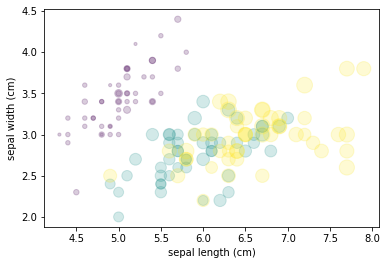

In [26]:
from sklearn.datasets import load_iris
iris = load_iris()
features = iris.data.T

plt.scatter(features[0], features[1], alpha=0.2,
            s=100*features[3], c=iris.target, cmap='viridis')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);

In [29]:
features[3]

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.3, 0.2, 0.2, 0.1, 0.2, 0.2, 0.1,
       0.1, 0.2, 0.4, 0.4, 0.3, 0.3, 0.3, 0.2, 0.4, 0.2, 0.5, 0.2, 0.2,
       0.4, 0.2, 0.2, 0.2, 0.2, 0.4, 0.1, 0.2, 0.2, 0.2, 0.2, 0.1, 0.2,
       0.2, 0.3, 0.3, 0.2, 0.6, 0.4, 0.3, 0.2, 0.2, 0.2, 0.2, 1.4, 1.5,
       1.5, 1.3, 1.5, 1.3, 1.6, 1. , 1.3, 1.4, 1. , 1.5, 1. , 1.4, 1.3,
       1.4, 1.5, 1. , 1.5, 1.1, 1.8, 1.3, 1.5, 1.2, 1.3, 1.4, 1.4, 1.7,
       1.5, 1. , 1.1, 1. , 1.2, 1.6, 1.5, 1.6, 1.5, 1.3, 1.3, 1.3, 1.2,
       1.4, 1.2, 1. , 1.3, 1.2, 1.3, 1.3, 1.1, 1.3, 2.5, 1.9, 2.1, 1.8,
       2.2, 2.1, 1.7, 1.8, 1.8, 2.5, 2. , 1.9, 2.1, 2. , 2.4, 2.3, 1.8,
       2.2, 2.3, 1.5, 2.3, 2. , 2. , 1.8, 2.1, 1.8, 1.8, 1.8, 2.1, 1.6,
       1.9, 2. , 2.2, 1.5, 1.4, 2.3, 2.4, 1.8, 1.8, 2.1, 2.4, 2.3, 1.9,
       2.3, 2.5, 2.3, 1.9, 2. , 2.3, 1.8])

In [28]:
features

array([[5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
        4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
        5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
        5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
        6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
        6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
        6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
        6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3,
        6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5,
        7.7, 7.7, 6. , 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2,
        7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6. , 6.9, 6.7, 6.9, 5.8,
        6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9],
       [3.5, 3. , 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1, 3.7, 3.4, 3. ,
        3. , 4. , 4.4, 3.9, 3.5, 3.8, 3.8, 3.4, 3.7, 3.6, 3.3, 3.4, 3. ,
       